## Camera Calibration
Compute the camera calibration matrix and distortion coefficients based on the given set of chessboard images.

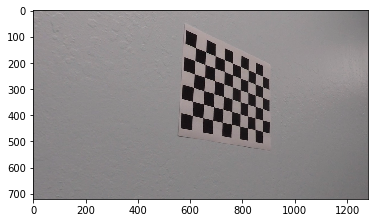

In [9]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from numpy import linalg as la
import os

# Globals
BLUE = (0,255,255)
FONT = cv2.FONT_HERSHEY_DUPLEX

nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# Setup output path
out_path = "./output_images/"
input_path = "./test_images/"
cali_path = "./camera_cal/"

# Read in a list of calibration images
cali_images = os.listdir(cali_path)
# print(images)

# Arrays to store object points and image points from all image points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

for image_file in cali_images:
    img = cv2.imread(cali_path + image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # draw_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # plt.imshow(draw_img)

# Camera calibration based on objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Show an example of undistorted image

for img_path in cali_images:
    img = cv2.imread(cali_path + img_path)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(undist)
    cv2.imwrite(os.path.join(out_path, "undist_check_"+img_path), undist)



## Distortion Correction

In [10]:
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Read in test images
test_images = os.listdir(input_path)

# Do distortion correction
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    cv2.imwrite(os.path.join(out_path, "undist_"+img_path), undist_img)


## Thresholded Binary Images

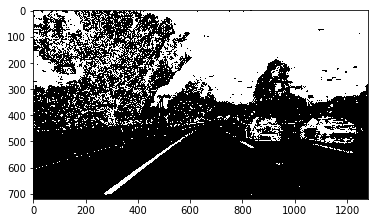

In [11]:
def threshold_image(img, sobelx_thresh = (30,110), h_thresh = (15,80), s_thresh = (160,255)):
    # Convert to HSV color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sobelx_thresh[0]) & (scaled_sobelx <= sobelx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Combine binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (h_binary == 1) | (sxbinary == 1) ] = 255
    return combined_binary

# Do thresholding binary images
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    
    # Display a binary image sample
    plt.imshow(th_undist_img, 'gray')
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "th_undist_"+ img_path), th_undist_img)

## Perspective Transform

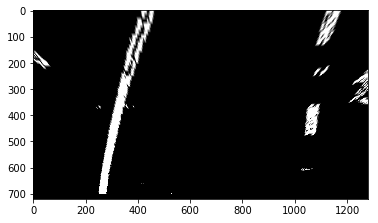

In [12]:
def perspective_trans(img, src, dst):
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# Manually select source and destination coordinates from straight lines
src = np.float32([[200,700],[555,470],[720,470],[1080,700]])
dst = np.float32([[190,700],[190,100],[980,100],[980,700]])

# Do perspective transform
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, _, _ = perspective_trans(th_undist_img, src, dst)
    
    # Display a binary image sample
    plt.imshow(warp_img, 'gray')
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "warp_"+ img_path), warp_img)

## Find Lane boundary
---
Using convolution technique.

In [13]:
def window_mask(width, height, img_ref, center, level):
    """To mask searching area inside image"""
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin, past_centroids = np.array([])):
    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create window template for convolutions
    window = np.ones(window_width) 
    
    if not past_centroids.shape[0]:         
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/3)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]*2/3):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]*2/3)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
    
        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            
            # Find the best left centroid by using past left center as a reference
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            if (la.norm(conv_signal[l_min_index:l_max_index])) > 10:
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            if (la.norm(conv_signal[r_min_index:r_max_index])) > 10:
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            window_centroids.append((l_center,r_center))
    
    else:        
        for level in range(0,(int)(warped.shape[0]/window_height)):
            # Using margin/2 this time as lane lines would not vary a lot from frame to frame
            margin = margin/2
            
            # Using past centeroids for each level as a reference
            l_center = past_centroids[level][0]
            r_center = past_centroids[level][1]
            
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),
                                        :], axis=0)
            conv_signal = np.convolve(window, image_layer)
 
            # Find the best left centroid by using center from previous frame as a reference
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            #l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            if (la.norm(conv_signal[l_min_index:l_max_index])) > 10:
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            # Find the best right centroid by using center from previous frame as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            #r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            if (la.norm(conv_signal[r_min_index:r_max_index])) > 10:
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            window_centroids.append((l_center,r_center))
            
    return np.asarray(window_centroids)
    
def draw_lane_finding(warped, window_centroids):
    """To draw lane findings back to warped image"""
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output
    # Display the final results
    # plt.imshow(output)
    # plt.title('window fitting results')
    # plt.show()

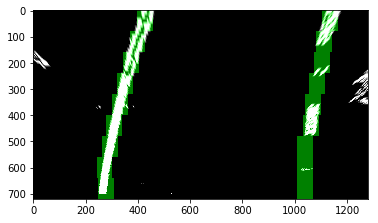

In [14]:
# window settings
window_width = 60 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 60 # How much to slide left and right for searching

# Do lane finding
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, M, Minv = perspective_trans(th_undist_img, src, dst)
    window_centroids = find_window_centroids(warp_img, window_width, window_height, margin)
    # print(np.asarray(window_centroids)[::-1])
    lane_output = draw_lane_finding(warp_img, window_centroids)
    # Display a binary image sample
    plt.imshow(lane_output)
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "lane_output_"+ img_path), lane_output)

## Create Polynomial Fit of Curve Lane Lines

In [15]:
def poly_fit_curves(window_centroids, window_height= 80, level=9):
    
    laney = np.linspace((720-window_height*level), 719, num=level)# to cover same y-range as image
    
    # Augment window centroids
    # window_centroids = np.asarray(window_centroids)
    leftx = window_centroids[:level, 0][::-1]  # Reverse to match top-to-bottom in y
    rightx = window_centroids[:level, 1][::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(laney, leftx, 2)
    right_fit = np.polyfit(laney, rightx, 2)
    
    # Interpolate lane lines based on fit result
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # find radius of curvature at bottom of image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(laney*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(laney*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate the distance from lane center
    left_dist = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_dist = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]
    
    center_offset = (left_dist+right_dist)/2 - 640*xm_per_pix
    return left_curverad, right_curverad, center_offset, left_fit, right_fit,\
        left_fitx, right_fitx, ploty, leftx, rightx, laney
    # Example values: 632.1 m    626.2 m


## Draw Lane Lines Back to World Image

In [16]:
def draw_lane_to_world(warp_img, undist_img, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result

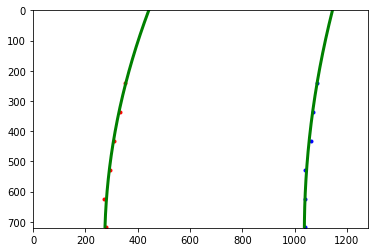

In [17]:
# Do polynomial fitting
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, M, Minv = perspective_trans(th_undist_img, src, dst)
    window_centroids = find_window_centroids(warp_img, window_width, window_height, margin)
    left_curverad, right_curverad, center_m, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, rightx, laney =\
    poly_fit_curves(window_centroids, level=6)

    # Plot lane lines from above
    plt.close()
    mark_size = 3
    plt.plot(leftx, laney, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, laney, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    plt.savefig(os.path.join(out_path, "poly_output_"+ img_path))
    
    # Draw lane lines back to world image
    lane_to_world = draw_lane_to_world(warp_img, undist_img, left_fitx, right_fitx, ploty)
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "lane_to_world_"+ img_path), lane_to_world)

## Video Process Pipeline

In [18]:


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = np.zeros([1, 720])
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros([1, 3]) 
        #polynomial coefficients for the most recent fit
        self.current_fit = np.zeros([1, 3]) 
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.array([])
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.array([])
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = np.array([])
        #y values for detected line pixels
        self.ally = np.array([])
        #the time old centroids were kept without update
        self.keep_count = 0
    
    def set_bestx(self, num):
        # Make sure to always calculate average based on how many data in array
        safe_num = min(num, self.recent_xfitted.shape[0]-1)
        # print(self.recent_xfitted)
        self.bestx = np.mean(self.recent_xfitted[-safe_num:], axis = 0)
        
    def set_best_fit(self, num):
        # Make sure to always calculate average based on how many data in array
        safe_num = min(num, self.current_fit.shape[0]-1)
        self.best_fit = np.mean(self.current_fit[-safe_num:], axis = 0)
        
    def set_current_fit(self, fit_coef, thres = 100):
        self.diffs = fit_coef - self.best_fit
        # Sanity check
        #print(la.norm(self.diffs))
        if not la.norm(self.current_fit) or la.norm(self.diffs) <= thres:
            self.current_fit = np.append(self.current_fit, [fit_coef], axis = 0)
            self.set_best_fit(5)
            return True
        else:
            return False
    
    # To add fitted line parameters
    def add_fit_line(self, fit_x, curve_m, center_m, detect_x):
        self.detected = True
        self.recent_xfitted = np.append(self.recent_xfitted, [fit_x], axis = 0)
        self.set_bestx(10)
        if abs(curve_m) < 1500:
            self.radius_of_curvature = np.append(self.radius_of_curvature, curve_m)
        if abs(center_m) < 0.5:
            self.line_base_pos = np.append(self.line_base_pos, center_m)
        self.allx = detect_x
        
    def sanity_check(self, fit_coef):
        return self.set_current_fit(fit_coef, 80)
    
    def get_curve(self, num=40):
        safe_num = min(num, self.radius_of_curvature.shape[0]-1)
        best_curve_m = np.mean(self.radius_of_curvature[-safe_num:])
        return best_curve_m
    
    def get_offset(self, num=40):
        safe_num = min(num, self.line_base_pos.shape[0]-1)
        best_off_m = np.mean(self.line_base_pos[-safe_num:])
        return best_off_m        
     

In [19]:
def video_lane_finding(image):
    undist_img = undistort_image(image, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, M, Minv = perspective_trans(th_undist_img, src, dst)
    
    # When lane detected in previous frame less than 5 times
    if l_line.detected and r_line.detected and l_line.keep_count + r_line.keep_count < 10:
        #print("line keep")
        window_centroids = find_window_centroids(warp_img, window_width, window_height, margin,
                                                 np.asarray([l_line.allx, r_line.allx]).T)
        l_line.keep_count += 1
        r_line.keep_count += 1
        
    # When lane lines not detected in previous frame or need updates
    else:
        #print("line find")
        window_centroids = find_window_centroids(warp_img, window_width, window_height, margin)
    # Do poly-fitting
    left_curverad, right_curverad, center_m, left_fit, right_fit, left_fitx, right_fitx, ploty, _,_,_ =\
        poly_fit_curves(window_centroids, level=6)
    
    # Draw centroids findings on top right
    lane_centroids = draw_lane_finding(warp_img, window_centroids)
    ds_centroids = cv2.resize(lane_centroids,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    boarder_centroids = cv2.copyMakeBorder(ds_centroids,30,510,960,0,cv2.BORDER_CONSTANT,value=[0,0,0])
    
    # Sanity check and add detected lines if pass
    pipeline_status = 'NOISY'
    if l_line.sanity_check(left_fit) and r_line.sanity_check(right_fit):
        l_line.add_fit_line(left_fitx, left_curverad, center_m, window_centroids[:,0])
        r_line.add_fit_line(right_fitx, right_curverad, center_m, window_centroids[:,1])
        pipeline_status = 'GOOD'
    
    # Draw best fit lines
    lane_img = draw_lane_to_world(warp_img, undist_img, l_line.bestx, r_line.bestx, ploty)
    
    # Draw curve and offset info    
    curverad = (l_line.get_curve() + r_line.get_curve()) / 2
    offset = (l_line.get_offset() + r_line.get_offset()) / 2
    
    # Assemble test with format
    curv_text = 'Curve Radius: ' + '{:04.2f}'.format(curverad) + 'm'
    if offset > 0:
        direction = 'Right'
    elif offset < 0:
        direction = 'Left'
    else:
        direction = ''
    off_text = direction + ' of Center: ' + '{:04.3f}'.format(abs(offset)) + 'm '
    
    
    # Draw pipeline working status
    stat_text = 'Detector Status: ' + pipeline_status
    
    # Overlay results   
    result = cv2.addWeighted(lane_img, 1, boarder_centroids, 1, 0)
    cv2.putText(result, 'Centroids Finding Results: ', (960,20), FONT, 0.6, BLUE, 1, cv2.LINE_AA)
    cv2.putText(result, curv_text, (960,230), FONT, 0.6, BLUE, 1, cv2.LINE_AA)
    cv2.putText(result, off_text, (960,260), FONT, 0.6, BLUE, 1, cv2.LINE_AA)
    cv2.putText(result, stat_text, (960,290), FONT, 0.6, BLUE, 1, cv2.LINE_AA)
    
    return result
        

In [20]:
# Test with sequence of images
l_line = Line()
r_line = Line()

# test6.jpg, test4.jpg, test5.jpg show in video in sequence
img = cv2.imread(input_path + 'test6.jpg')
cv2.imwrite(os.path.join(out_path, "video_pipeline_"+ 'test6.jpg'), video_lane_finding(img))
img = cv2.imread(input_path + 'test4.jpg')
cv2.imwrite(os.path.join(out_path, "video_pipeline_"+ 'test4.jpg'), video_lane_finding(img))
img = cv2.imread(input_path + 'test5.jpg')
cv2.imwrite(os.path.join(out_path, "video_pipeline_"+ 'test5.jpg'), video_lane_finding(img))

True

In [23]:
# Create variable to store lane line findings
l_line = Line()
r_line = Line()

from moviepy.editor import VideoFileClip

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(30,40)
processed_video = video_input1.fl_image(video_lane_finding)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:38<00:00,  7.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 26s, sys: 29.2 s, total: 3min 55s
Wall time: 2min 39s


In [22]:
# Create variable to store lane line findings
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(30,45)
processed_video = video_input2.fl_image(video_lane_finding)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:56<00:00,  8.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 15s, sys: 9.3 s, total: 1min 24s
Wall time: 56.8 s
